<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_PreprocessingV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Skrip Google Colab V3: Preprocessing dan Ekstraksi Multi-Fitur
(Termasuk Kelas Negatif / Bukan Uang) + VISUALISASI ANALISIS

Metode:
- Preprocessing: Resize, Gaussian Blur, Konversi BGR ke HSV & Grayscale
- Ekstraksi Fitur (Gabungan):
    1. Fitur Warna: Histogram (Hue + Saturation)
    2. Fitur Tekstur: Local Binary Patterns (LBP)
    3. Fitur Bentuk: Hu Moments
- Output: File .joblib v3 baru
- Visualisasi: Membandingkan rata-rata fitur antar kelas di akhir proses.

# LANGKAH 1: IMPORT LIBRARY DAN MOUNT DRIVE

In [1]:
!pip install scikit-image

import os
import cv2
import numpy as np
import joblib
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import seaborn as sns

# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


# LANGKAH 2: KONFIGURASI

In [5]:
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'

# --- UPDATE PENTING: NAMA FOLDER DISESUAIKAN ---
# Mengubah '0_bukan_uang' menjadi 'negative' sesuai folder Anda
LABELS = ['negative', '1000', '2000', '5000', '10000', '20000', '50000', '100000']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

# --- Parameter ---
IMG_SIZE = (250, 250)
H_BINS = 180
S_BINS = 256
LBP_POINTS = 24
LBP_RADIUS = 8
LBP_BINS = int(LBP_POINTS + 2)

print(f"Path utama: {BASE_DIR}")
print(f"Kelas yang akan diproses: {LABELS}")

Path utama: /content/drive/MyDrive/tugas_akhir_semester5/raw_data
Kelas yang akan diproses: ['negative', '1000', '2000', '5000', '10000', '20000', '50000', '100000']


# LANGKAH 3: FUNGSI EKSTRAKSI FITUR

In [6]:
def extract_features_v3(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return None

        # Resize & Blur
        image = cv2.resize(image, IMG_SIZE)
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # Konversi Ruang Warna
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # --- 1. WARNA (HSV) ---
        # Hue Histogram
        h_hist = cv2.calcHist([hsv_image], [0], None, [H_BINS], [0, 180])
        h_hist = cv2.normalize(h_hist, None, 0, 1, cv2.NORM_MINMAX).flatten()

        # Saturation Histogram
        s_hist = cv2.calcHist([hsv_image], [1], None, [S_BINS], [0, 256])
        s_hist = cv2.normalize(s_hist, None, 0, 1, cv2.NORM_MINMAX).flatten()

        # --- 2. TEKSTUR (LBP) ---
        lbp = local_binary_pattern(gray_image, LBP_POINTS, LBP_RADIUS, method='uniform')
        (texture_features, _) = np.histogram(lbp.ravel(), bins=LBP_BINS, range=(0, LBP_BINS))
        texture_features = cv2.normalize(texture_features.astype('float'), None, 0, 1, cv2.NORM_MINMAX).flatten()

        # --- 3. BENTUK (HU MOMENTS) ---
        _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        moments = cv2.moments(thresh)
        hu_moments = cv2.HuMoments(moments)
        # Log scale agar rentang nilai tidak terlalu jauh
        shape_features = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-7)
        shape_features = shape_features.flatten()

        # --- GABUNGKAN ---
        # Urutan: Hue (180) + Saturation (256) + Texture (26) + Shape (7)
        final_feature_vector = np.concatenate((h_hist, s_hist, texture_features, shape_features))

        return final_feature_vector

    except Exception as e:
        print(f"Error memproses {image_path}: {e}")
        return None

# LANGKAH 4: PROSES DATASET

In [7]:
print("\nMemulai pemrosesan dataset V3...")

data_features = []
data_labels = []
data_counts = {}

for label in LABELS:
    label_path = os.path.join(BASE_DIR, label)

    if not os.path.isdir(label_path):
        print(f"Skip: Folder '{label}' tidak ditemukan.")
        continue

    image_files = [f for f in os.listdir(label_path) if f.lower().endswith(VALID_EXTENSIONS)]
    data_counts[label] = len(image_files)
    print(f"Memproses folder: {label} ({len(image_files)} gambar)")

    for image_file in tqdm(image_files, desc=f"Kelas {label}"):
        full_path = os.path.join(label_path, image_file)
        features = extract_features_v3(full_path)

        if features is not None:
            data_features.append(features)
            data_labels.append(label)


Memulai pemrosesan dataset V3...
Memproses folder: negative (303 gambar)


Kelas negative: 100%|██████████| 303/303 [00:24<00:00, 12.17it/s]


Memproses folder: 1000 (240 gambar)


Kelas 1000: 100%|██████████| 240/240 [00:25<00:00,  9.32it/s]


Memproses folder: 2000 (240 gambar)


Kelas 2000: 100%|██████████| 240/240 [01:09<00:00,  3.45it/s]


Memproses folder: 5000 (224 gambar)


Kelas 5000: 100%|██████████| 224/224 [00:52<00:00,  4.24it/s]


Memproses folder: 10000 (240 gambar)


Kelas 10000: 100%|██████████| 240/240 [00:37<00:00,  6.34it/s]


Memproses folder: 20000 (240 gambar)


Kelas 20000: 100%|██████████| 240/240 [00:28<00:00,  8.39it/s]


Memproses folder: 50000 (227 gambar)


Kelas 50000: 100%|██████████| 227/227 [00:35<00:00,  6.33it/s]


Memproses folder: 100000 (240 gambar)


Kelas 100000: 100%|██████████| 240/240 [01:02<00:00,  3.84it/s]


# LANGKAH 5: SIMPAN HASIL

In [8]:
if not data_features:
    print("Tidak ada data yang diproses.")
else:
    X = np.array(data_features)
    y = np.array(data_labels)

    print(f"\nBentuk (shape) X: {X.shape}")
    print(f"Bentuk (shape) y: {y.shape}")

    save_path_X = os.path.join(BASE_DIR, 'features_X_v3.joblib')
    save_path_y = os.path.join(BASE_DIR, 'labels_y_v3.joblib')

    joblib.dump(X, save_path_X)
    joblib.dump(y, save_path_y)
    print(f"Data disimpan ke: {save_path_X}")


Bentuk (shape) X: (1954, 469)
Bentuk (shape) y: (1954,)
Data disimpan ke: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/features_X_v3.joblib


# LANGKAH 7: VISUALISASI ANALISIS FITUR


--- MENYIAPKAN VISUALISASI ANALISIS FITUR ---


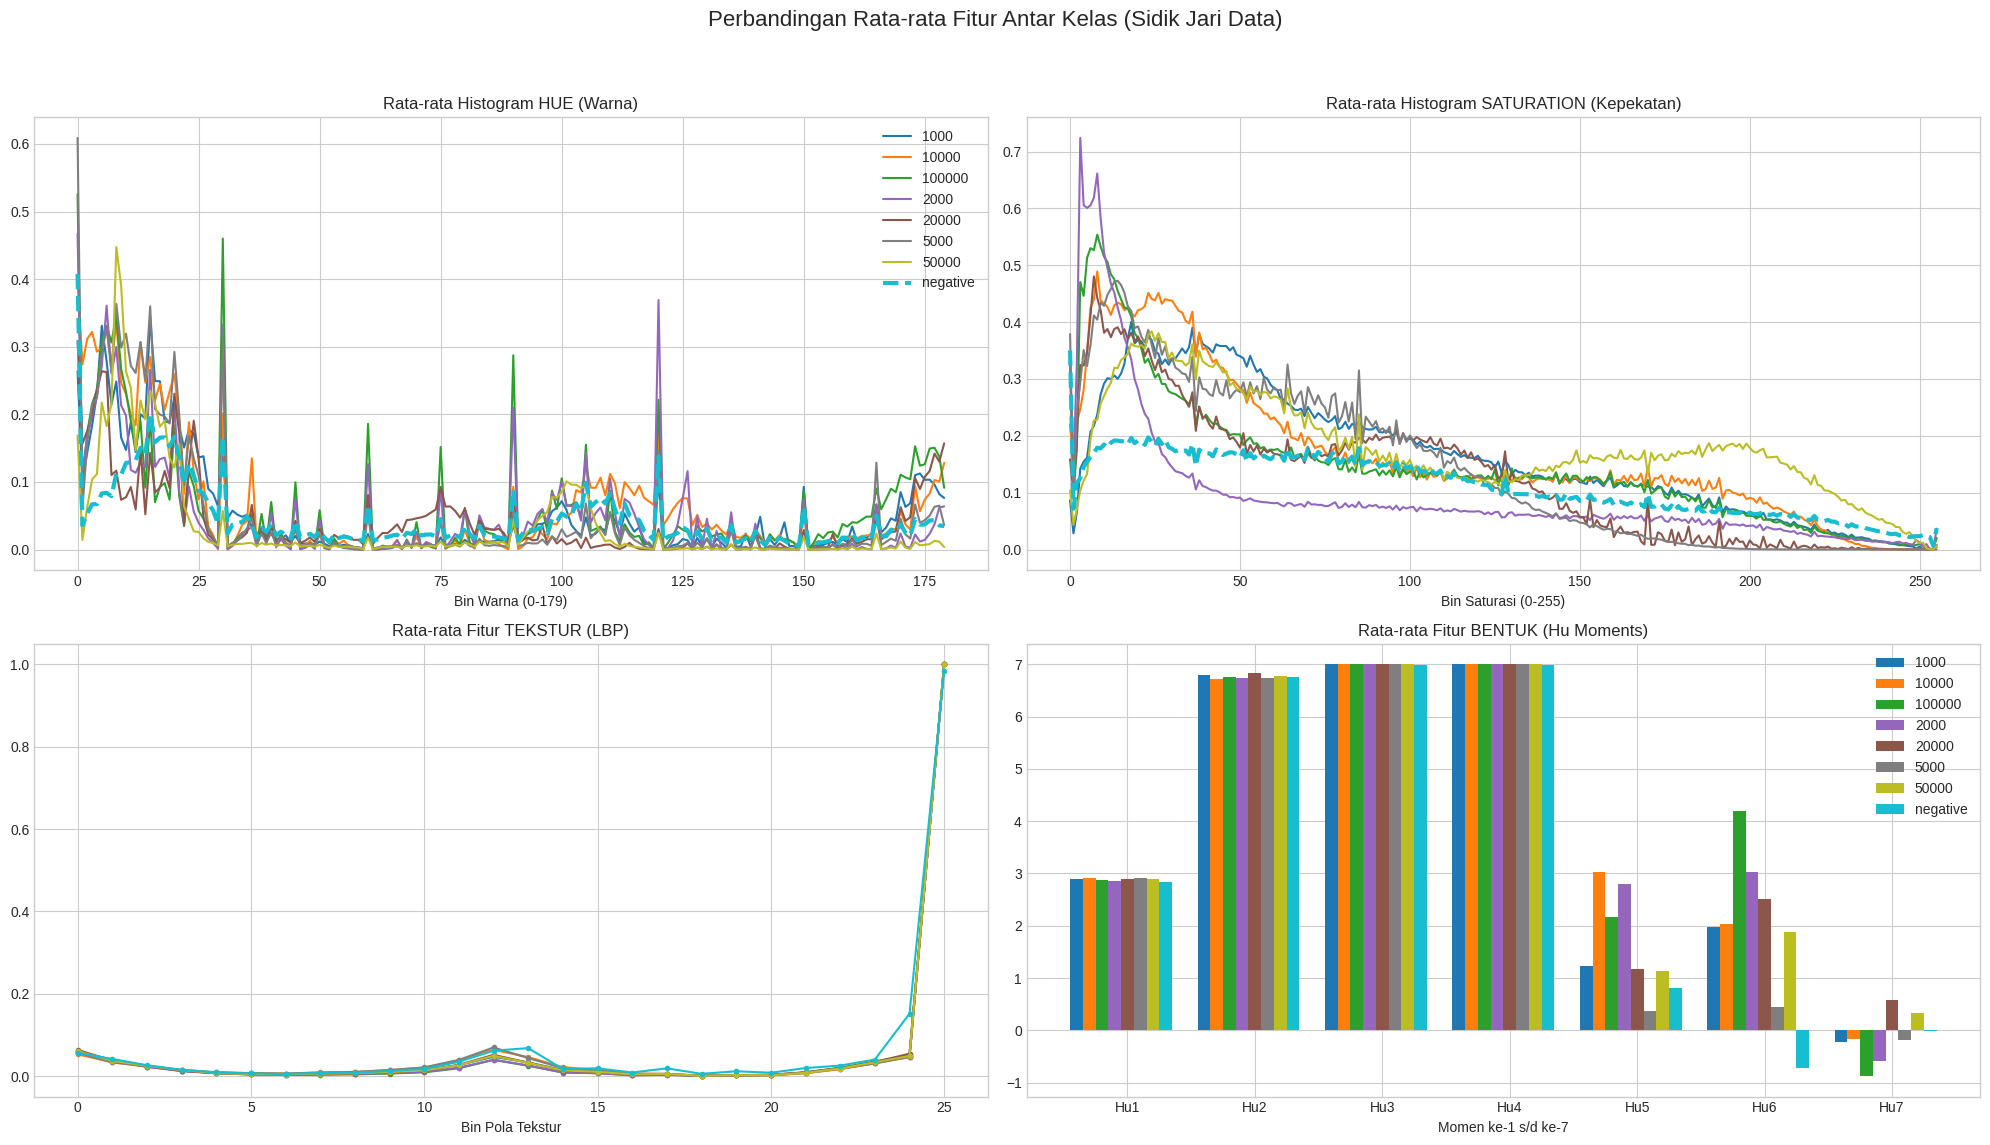


Analisis Visual Selesai.
Garis putus-putus (jika ada) menunjukkan kelas 'negative'.


In [9]:
if len(data_features) > 0:
    print("\n--- MENYIAPKAN VISUALISASI ANALISIS FITUR ---")

    # 1. Hitung Rata-rata Fitur per Kelas
    unique_labels = np.unique(y)
    class_averages = {}

    for label in unique_labels:
        indices = np.where(y == label)[0]
        class_data = X[indices]
        average_vector = np.mean(class_data, axis=0)
        class_averages[label] = average_vector

    # 2. Definisikan Batas Index Fitur
    idx_hue_end = H_BINS
    idx_sat_end = H_BINS + S_BINS
    idx_tex_end = idx_sat_end + LBP_BINS

    # 3. Plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    plt.suptitle("Perbandingan Rata-rata Fitur Antar Kelas (Sidik Jari Data)", fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # --- PLOT 1: HISTOGRAM HUE ---
    ax = axes[0, 0]
    for i, label in enumerate(unique_labels):
        avg_vec = class_averages[label]
        hue_feature = avg_vec[:idx_hue_end]
        # Highlight khusus untuk kelas 'negative'
        lw = 3 if label=='negative' else 1.5
        ls = '--' if label=='negative' else '-'
        ax.plot(hue_feature, label=label, color=colors[i], linewidth=lw, linestyle=ls)
    ax.set_title("Rata-rata Histogram HUE (Warna)")
    ax.set_xlabel("Bin Warna (0-179)")
    ax.legend()

    # --- PLOT 2: HISTOGRAM SATURATION ---
    ax = axes[0, 1]
    for i, label in enumerate(unique_labels):
        avg_vec = class_averages[label]
        sat_feature = avg_vec[idx_hue_end:idx_sat_end]
        lw = 3 if label=='negative' else 1.5
        ls = '--' if label=='negative' else '-'
        ax.plot(sat_feature, label=label, color=colors[i], linewidth=lw, linestyle=ls)
    ax.set_title("Rata-rata Histogram SATURATION (Kepekatan)")
    ax.set_xlabel("Bin Saturasi (0-255)")

    # --- PLOT 3: HISTOGRAM TEXTURE (LBP) ---
    ax = axes[1, 0]
    for i, label in enumerate(unique_labels):
        avg_vec = class_averages[label]
        tex_feature = avg_vec[idx_sat_end:idx_tex_end]
        ax.plot(tex_feature, label=label, color=colors[i], marker='o', markersize=3)
    ax.set_title("Rata-rata Fitur TEKSTUR (LBP)")
    ax.set_xlabel("Bin Pola Tekstur")

    # --- PLOT 4: SHAPE (Hu Moments) ---
    ax = axes[1, 1]
    x_axis = np.arange(7)
    width = 0.1

    for i, label in enumerate(unique_labels):
        avg_vec = class_averages[label]
        shape_feature = avg_vec[idx_tex_end:]
        ax.bar(x_axis + (i * width), shape_feature, width=width, label=label, color=colors[i])

    ax.set_title("Rata-rata Fitur BENTUK (Hu Moments)")
    ax.set_xlabel("Momen ke-1 s/d ke-7")
    ax.set_xticks(x_axis + width * len(unique_labels) / 2)
    ax.set_xticklabels([f"Hu{i+1}" for i in range(7)])
    ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nAnalisis Visual Selesai.")
    print("Garis putus-putus (jika ada) menunjukkan kelas 'negative'.")